In [340]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from labellines import labelLine, labelLines  # will first need to install labellines package
from matplotlib.pyplot import cm

seedno = 12345
rng = np.random.default_rng(seed=seedno)

In [341]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
# font size for labels in plots
fs = 15
dpi = 300
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

## Model parameters

In [342]:
lambda_a = 1. #buying
lambda_b = 1. #selling
kappa = 100. #intensity
s = 1. #Oracle price
depth = 1000000 #depth of the pool
q_min = 980 #minimum quantity of asset Y
q_max = 1020 #maximum quantity of asset Y
T=1

# changes font in plots
fontnm = "Times New Roman" 
tnrfont = {'fontname':fontnm} 

In [343]:
def varphi(x): # we work in CPMM
    return depth/x

In [344]:
def varphi_der(x): # instant price
    return -depth/(x**2)

In [345]:
q_vector = np.ones((q_max - q_min))
q_vector = [i + q_min for i in range(q_max - q_min)]

## Implementation

In [346]:
def _calculate_omega_t(t,c):
    A_matrix = np.zeros((q_max - q_min + 1,q_max-q_min + 1))
    vector = np.ones((q_max - q_min + 1 , 1))  
    for i in range(q_max - q_min + 1):
        quantity = i + q_min
        A_matrix[i,i] = -c*(varphi_der(quantity) + s)**2
        if i + 1 < q_max - q_min:
            A_matrix[i,i+1] = lambda_b * np.exp(- kappa*(varphi(quantity) - (varphi(quantity+1)))) * np.exp( kappa * s - 1)
        if i > 0:
            A_matrix[i,i-1] = lambda_a * np.exp(kappa*(varphi(quantity-1) - varphi(quantity))) * np.exp( - kappa * s - 1)
    return np.matmul(expm(A_matrix*(T-t) ), vector)

In [347]:
def _calculate_gt(t,c): # Compute the function g
    omega_function = _calculate_omega_t(t,c)
    return (1 / kappa) * np.log(omega_function)

In [348]:
def _calculate_fees(t,c): # Compute the best fees
    g_qs = _calculate_gt(t,c)
    alpha = np.ones((q_max - q_min))
    beta = np.ones((q_max - q_min))
    for i in range(q_max - q_min):
        quantity = i + q_min
        alpha[i] = 1/(kappa*(varphi(quantity) - varphi(quantity+1))) - (g_qs[i+1,0] - g_qs[i,0])/(varphi(quantity) - varphi(quantity+1))
        beta[i] = 1/(kappa*(varphi(quantity-1) - varphi(quantity))) + (g_qs[i,0] - g_qs[i-1,0])/(varphi(quantity-1) - varphi(quantity))
    alpha[-1] = np.NaN
    beta[0] = np.NaN
    return alpha, beta

In [349]:
pen_constant = np.zeros(6)
for i in range(0,5):
    pen_constant[i+1] = 10**i

In [350]:
t=0.5
alpha = np.ones((q_max - q_min,len(pen_constant)))
beta = np.ones((q_max - q_min,len(pen_constant)))
for i,c in enumerate(pen_constant):
    alpha[:,i],beta[:,i] = _calculate_fees(t,c)

## Plots

In [351]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
#from labellines import labelLines  # Assuming labelLines is imported from somewhere

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(pen_constant), vmax=max(pen_constant))
sm = ScalarMappable(norm=norm, cmap=cmap)

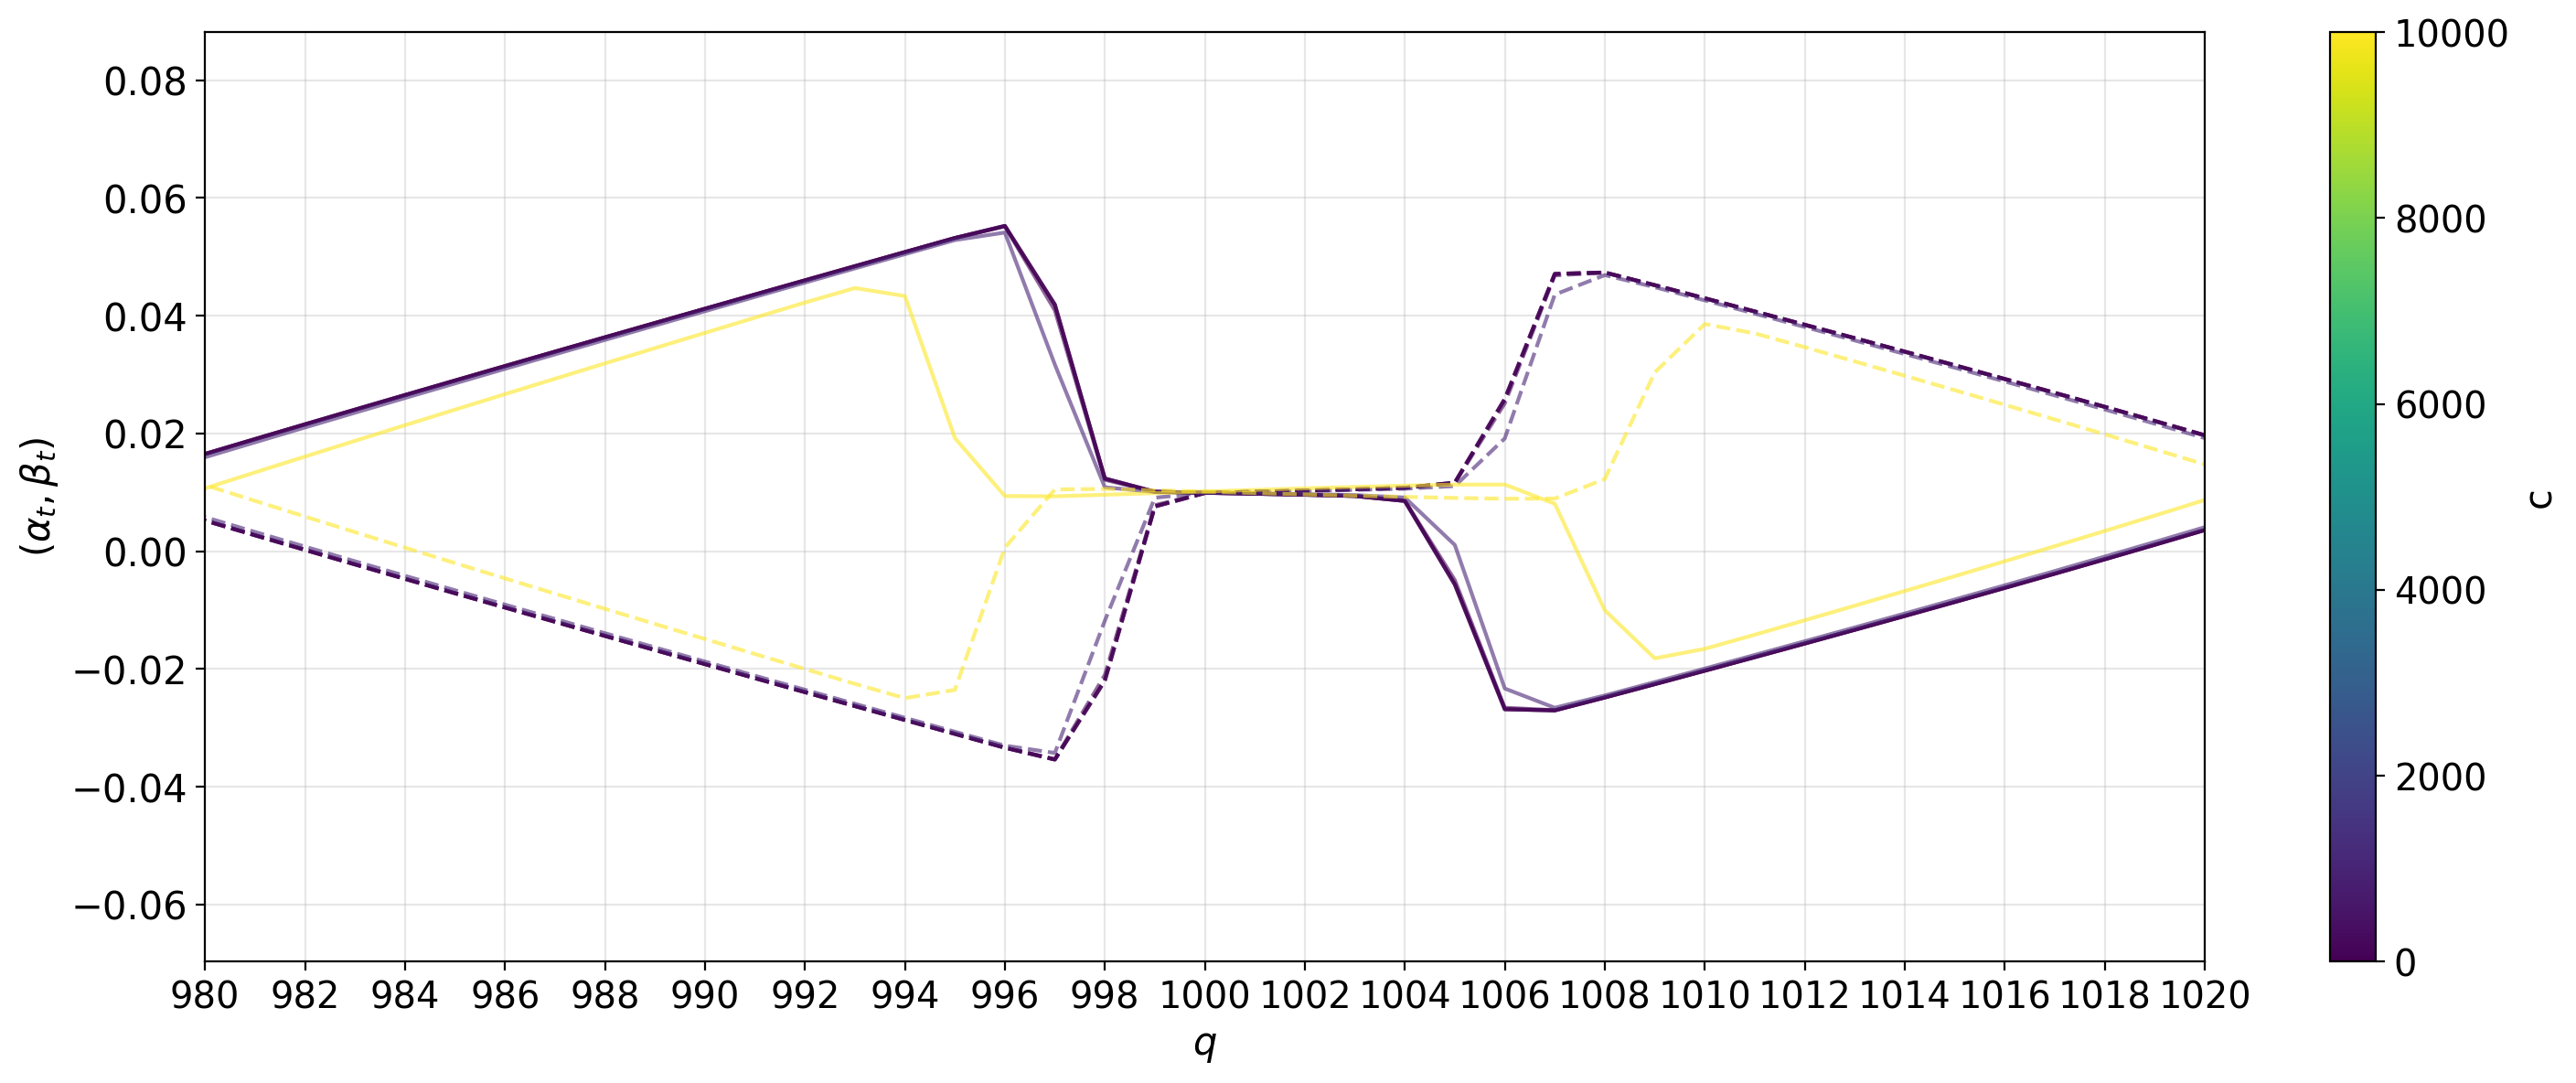

In [352]:
fig, ax = plt.subplots(1, 1, figsize = (15,6), sharey=False, sharex=True)

for i,q in enumerate(pen_constant):
    color = cmap(norm(pen_constant[i]))
    ax.plot(q_vector,alpha[:,i], '-', color=color, alpha=0.6)
    ax.plot(q_vector,beta[:,i], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$q$', fontsize=fs)
plt.xticks(range(q_min,q_max +1,2))
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)
plt.xlim([980,1020])
# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label(r"c", fontsize=fs)

plt.tight_layout()
#plt.savefig('figures/approxoptdepths.pdf', format="pdf", dpi=dpi)

plt.show()

In [353]:
t_vector = np.linspace(0,T,num=100)

c = 0

alpha = np.ones((q_max - q_min,len(t_vector)))
beta = np.ones((q_max - q_min,len(t_vector)))
for i,t in enumerate(t_vector):
    alpha[:,i],beta[:,i] = _calculate_fees(t,c)

In [354]:
cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(q_vector), vmax=max(q_vector))
sm = ScalarMappable(norm=norm, cmap=cmap)

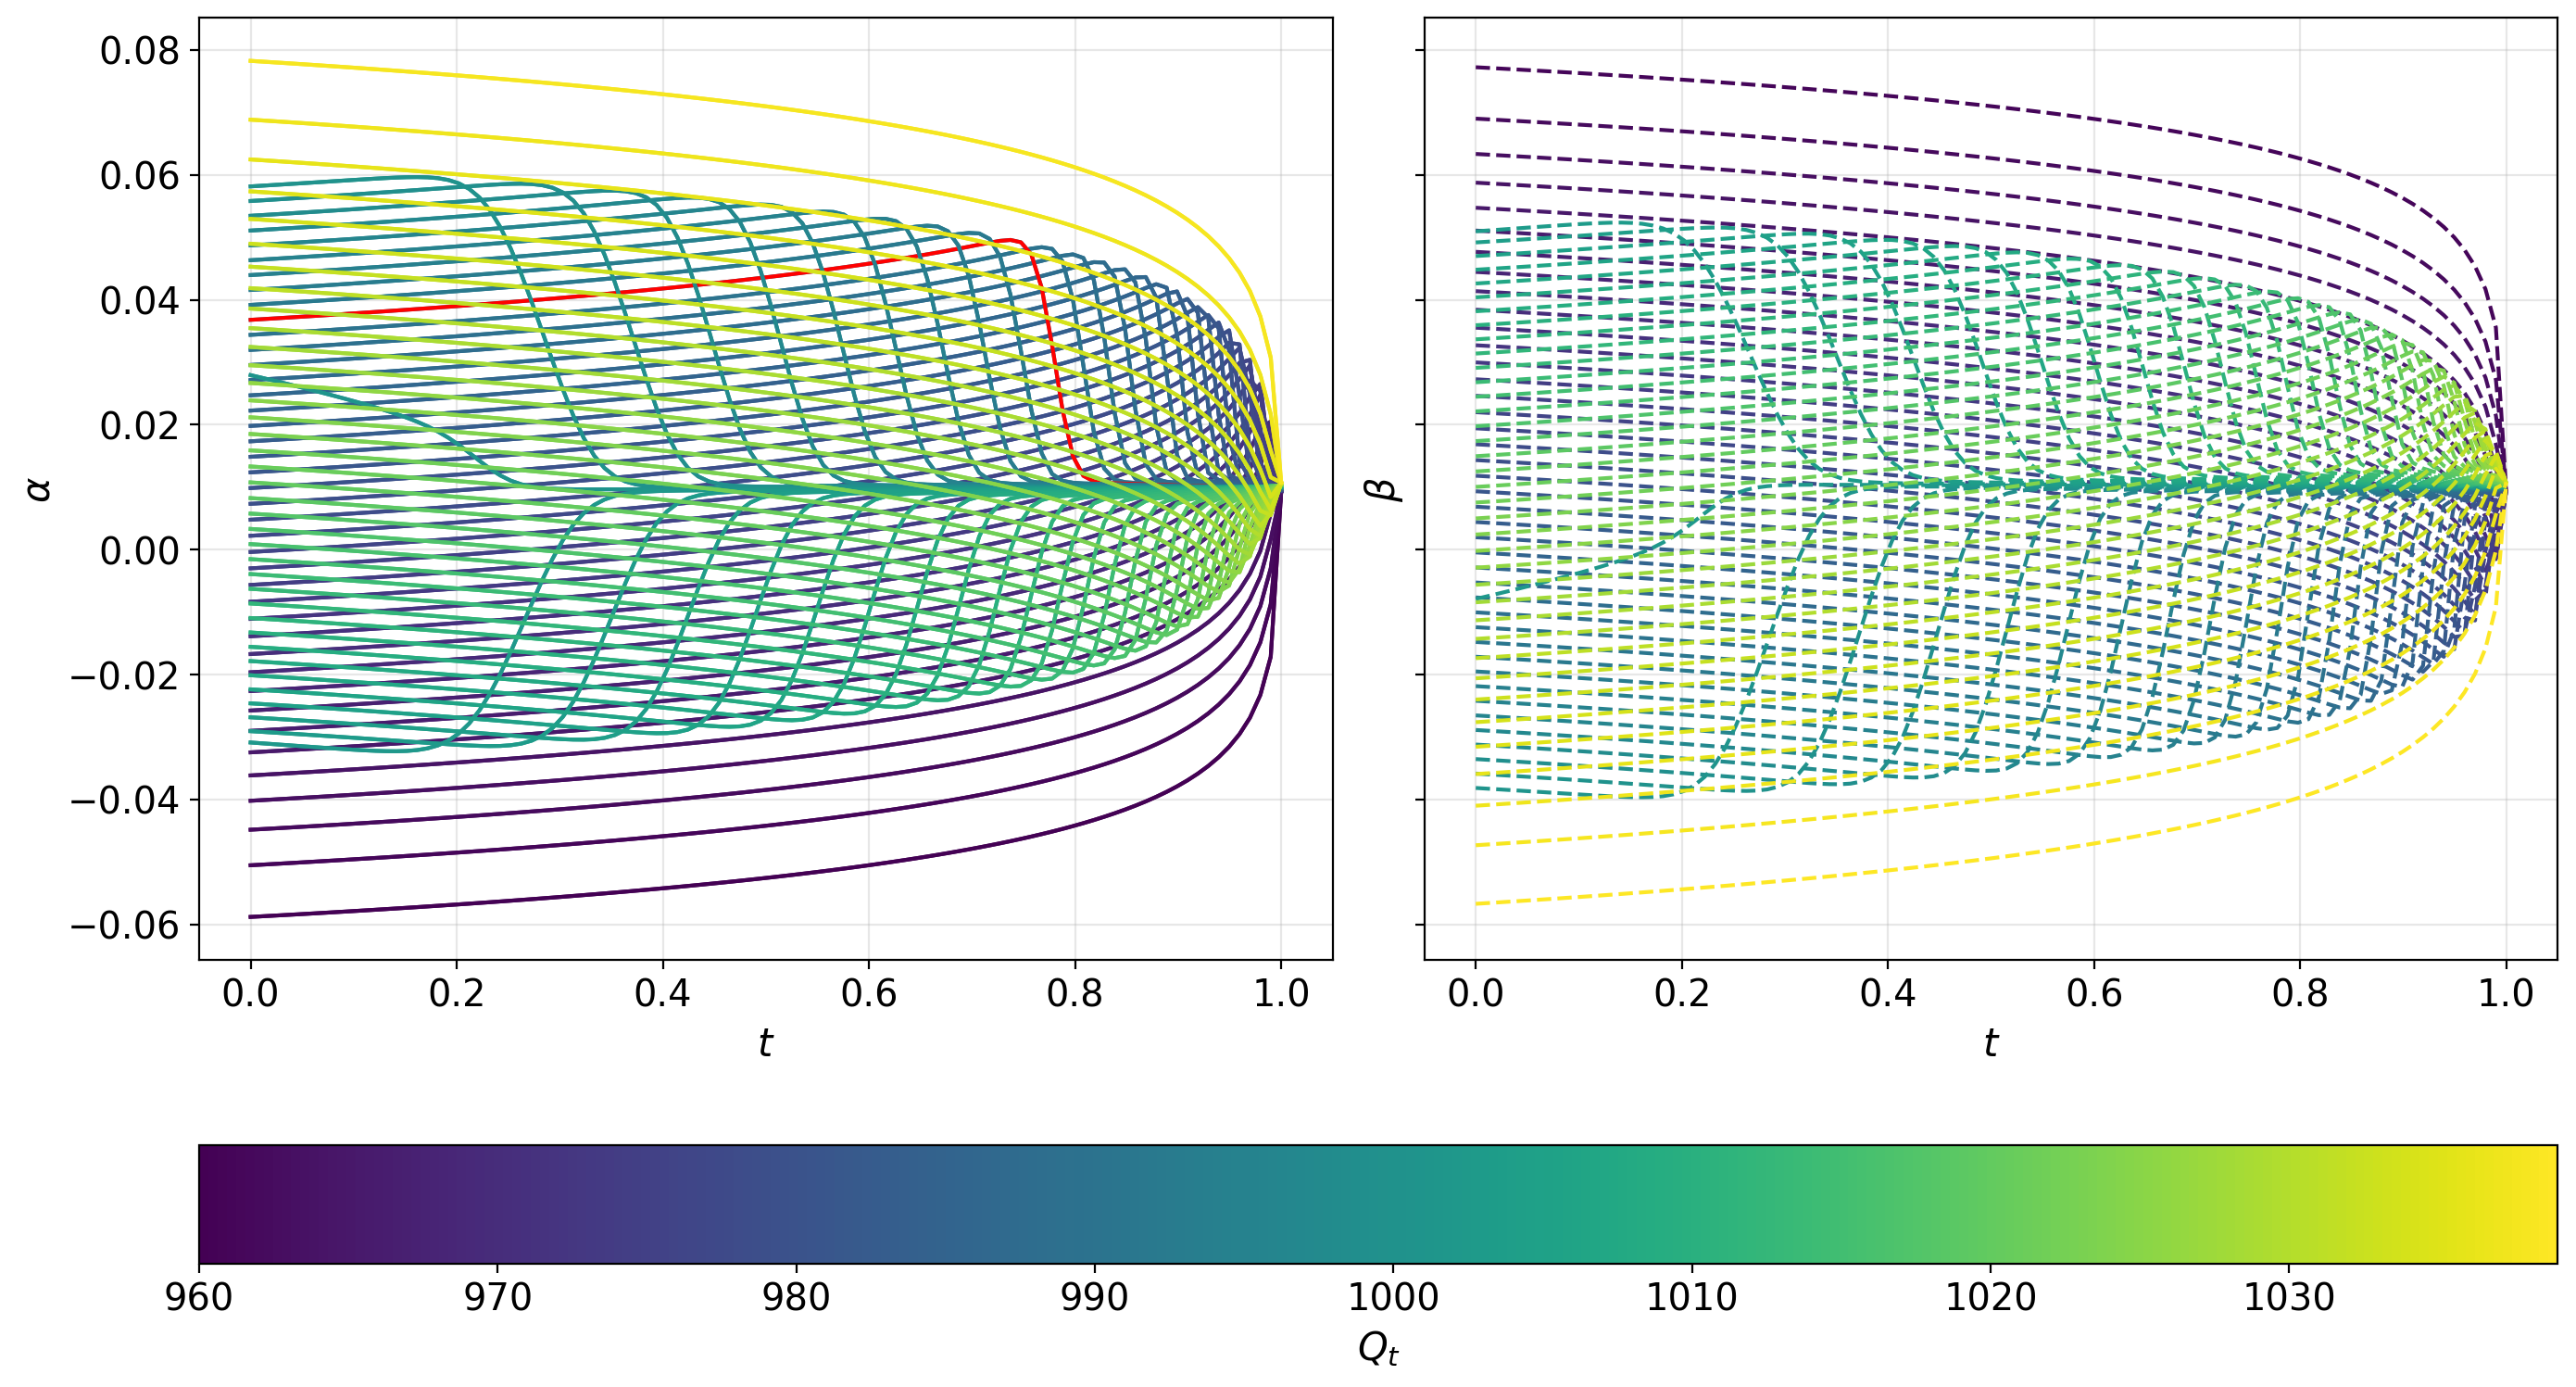

In [355]:
#colors = cm.rainbow(np.linspace(0.6, 1, len(q_vector)))


fig, ax = plt.subplots(1,2, figsize = (14,8), sharey=True)
for i,q in enumerate(q_vector):
    color = cmap(norm(q_vector[i]))
    if q < q_max:
        ax[0].plot(t_vector, alpha[i,:],'-', color = color)#, label="q="+str(q), colors[iq])
    if q == 991:
        ax[0].plot(t_vector, alpha[i,:],'-', color = "red")#, label="q="+str(q), colors[iq])
    else:
        ax[0].plot(t_vector, alpha[i,:],'-', color = color) #colors[iq])
    
for i,q in enumerate(q_vector):
    color = cmap(norm(q_vector[i]))
    if q > q_min:
        ax[1].plot(t_vector, beta[i,:],'--', color = color) #, label="q="+str(q), colors[iq])
    else:
        ax[1].plot(t_vector, beta[i,:],'--', color = color) # label=" ", colors[iq])
        

        
ax[0].set_xlabel(r'$t$', fontsize = fs)
ax[1].set_xlabel(r'$t$', fontsize = fs)
ax[0].set_ylabel(r'$\alpha$', fontsize = fs)
ax[1].set_ylabel(r'$\beta$', fontsize = fs)
labelLines(ax[0].get_lines(), zorder=2.5)
#labelLines(ax[1].get_lines(), zorder=2.5)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

plt.tight_layout()

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.14)
cbar.set_label(r'$Q_t$', fontsize=fs)

#plt.tight_layout()


#cbar = fig.colorbar(sm, ax=ax[1], orientation='vertical')

#cbar.set_label(r'$\tilde{Q}_t$', fontsize=fs)
#plt.savefig('figures/delta_through_time_fct_of_Q_t.pdf', format="pdf", dpi=dpi)
plt.show()